In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import copy

## Load Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eswarchandt/admission")

print("Path to dataset files:", path)

Path to dataset files: /home/mohsen/.cache/kagglehub/datasets/eswarchandt/admission/versions/1


In [3]:
data = pd.read_excel(path + "/Admission.xlsx")
# data = data.sample(frac=0.1, random_state=1)
data.head()

,admit,gre,gpa,ses,Gender_Male,Race,rank
0,0,380,3.61,1,0,3,3
1,1,660,3.67,2,0,2,3
2,1,800,4.00,2,0,2,1
3,1,640,3.19,1,1,2,4
4,0,520,2.93,3,1,2,4


Preprocess

In [4]:
gre, gpa = data["gre"], data["gpa"]

data["gre"] = (gre - gre.min()) / (gre.max() - gre.min())
data["gpa"] = (gpa - gpa.min()) / (gpa.max() - gpa.min())

In [5]:
points = data[["gpa", "gre", "Gender_Male"]]

In [6]:
points.head()

,gpa,gre,Gender_Male
0,0.775862,0.275862,0
1,0.810345,0.758621,0
2,1.000000,1.000000,0
3,0.534483,0.724138,1
4,0.385057,0.517241,1


In [8]:
data.shape

(400, 7)

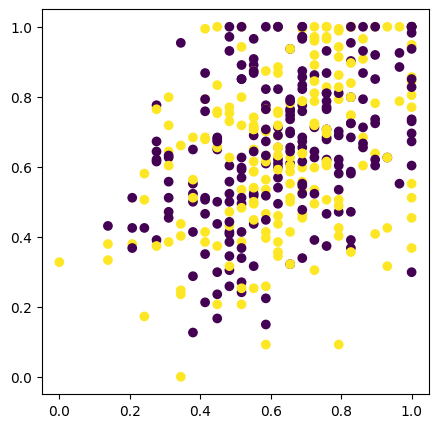

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(points['gre'], points['gpa'], c=points["Gender_Male"]);

In [9]:
female = points[points["Gender_Male"] == 0]
male = points[points["Gender_Male"] == 1]
female.shape[0] / male.shape[0]

1.105263157894737

## K Means

In [10]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'Normalized GPA')

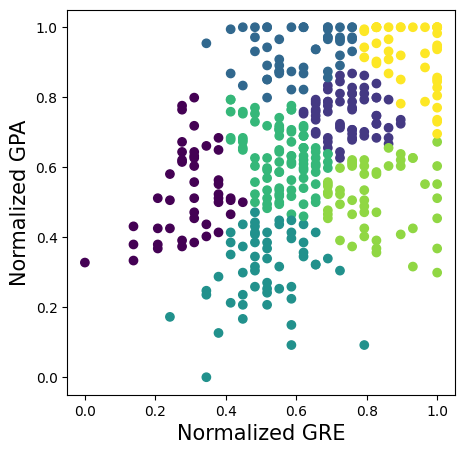

In [14]:
n = 7
X = points[["gre", "gpa"]].to_numpy()
kmeans = KMeans(n_clusters=n, random_state=1, n_init="auto").fit(X)
plt.figure(figsize=(5, 5))
colors = kmeans.predict(X)
plt.scatter(X[:,0], X[:,1], c=colors)
plt.xlabel("Normalized GRE", fontsize=15)
plt.ylabel("Normalized GPA", fontsize=15)
# plt.savefig("clustering_admissions.eps", format="eps")

In [15]:
clusters = pd.DataFrame(X)
colors = pd.DataFrame(colors)
clusters["colors"] = colors
clusters["gender"] = points["Gender_Male"]
clusters.head()

,0,1,colors,gender
0,0.275862,0.775862,0,0
1,0.758621,0.810345,1,0
2,1.000000,1.000000,6,0
3,0.724138,0.534483,5,1
4,0.517241,0.385057,3,1


In [20]:
for c in clusters["colors"].unique():
    tmp = clusters[clusters["colors"] == c]
    print(f"cluster: {c}", "female/male: ", tmp["gender"].value_counts()[0] / tmp["gender"].value_counts()[1], "size: ", len(tmp))

cluster: 0 female/male:  1.368421052631579 size:  45
cluster: 1 female/male:  1.9047619047619047 size:  61
cluster: 6 female/male:  0.9565217391304348 size:  45
cluster: 5 female/male:  1.0384615384615385 size:  53
cluster: 3 female/male:  0.9642857142857143 size:  55
cluster: 4 female/male:  0.8 size:  90
cluster: 2 female/male:  1.2173913043478262 size:  51


Generate Report

In [33]:
X = points[["gre", "gpa"]].to_numpy()

result = {
    "k": [],
    "ratio": [],
    "size": [],
    "cluster_id": []
}

for k in [2, 3, 4, 5, 6, 7]:
    kmeans = KMeans(n_clusters=k, n_init="auto").fit(X)
    colors = kmeans.predict(X)
    clusters = pd.DataFrame(X)
    colors = pd.DataFrame(colors)
    clusters["colors"] = colors
    clusters["gender"] = points["Gender_Male"]
    
    for c in clusters["colors"].unique():
        tmp = clusters[clusters["colors"] == c]

        result["cluster_id"].append(c)
        result["k"].append(k)
        result["ratio"].append(tmp["gender"].value_counts()[0] / tmp["gender"].value_counts()[1])
        result["size"].append(len(tmp))
result = pd.DataFrame(result)

In [7]:
# result.to_csv("./reports/admission_clustering.csv", index=0)
result = pd.read_csv("./reports/admission_clustering.csv")
result.head()

,k,ratio,size,cluster_id
0,2,0.970588,201,0
1,2,1.261364,199,1
2,3,1.206897,128,1
3,3,1.092308,136,2
4,3,1.029851,136,0


In [36]:
result.groupby("k").max()

,ratio,size,cluster_id
k,,,
2,1.261364,201,1
3,1.206897,136,2
4,1.204545,104,3
5,1.500000,108,4
6,1.444444,90,5
7,1.500000,93,6


In [38]:
result[result["k"] == 5].sort_values("cluster_id")

,k,ratio,size,cluster_id
10,5,0.957447,92,0
12,5,0.945946,72,1
13,5,1.117647,108,2
9,5,1.500000,45,3
11,5,1.243243,83,4


# AffinityPropagation

In [8]:
from sklearn.cluster import AffinityPropagation

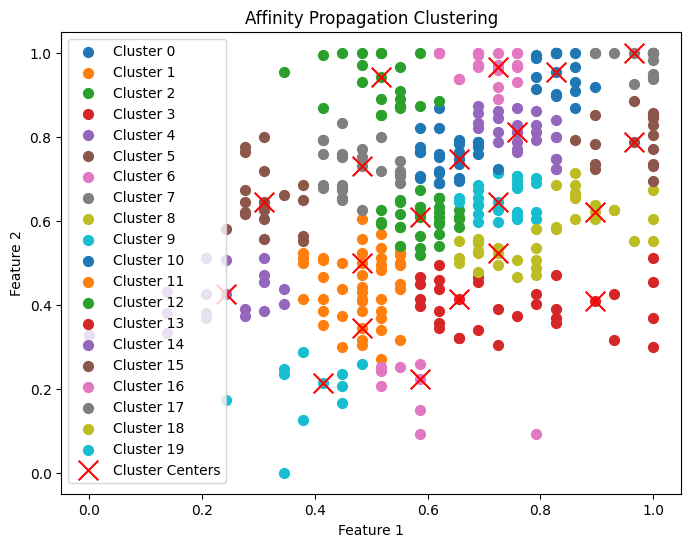

In [9]:
X = points[["gre", "gpa"]].to_numpy()

# Step 2: Apply Affinity Propagation
affinity_propagation = AffinityPropagation()
labels = affinity_propagation.fit_predict(X)
cluster_centers = affinity_propagation.cluster_centers_

# Step 3: Visualize Results
unique_labels = np.unique(labels)
plt.figure(figsize=(8, 6))

# Plot each cluster with a different color
for label in unique_labels:
    cluster_points = X[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", s=50)

# Mark the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label="Cluster Centers")

plt.title("Affinity Propagation Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [10]:
clusters = pd.DataFrame(X)
colors = pd.DataFrame(labels)
clusters["colors"] = colors
clusters["gender"] = points["Gender_Male"]
ratios = []
sizes = []
for c in np.unique(clusters["colors"]):
    tmp = clusters[clusters["colors"] == c]
    # print(f"cluter: {c}, \nfemale: {tmp['gender'].value_counts()}\n")
    # if len(tmp["gender"].value_counts()) > 1:
    ratios.append(tmp["gender"].value_counts()[0] / tmp["gender"].value_counts()[1])
    sizes.append(len(tmp))
    print(f"cluster: {c}", "female/male: ", tmp["gender"].value_counts()[0] / tmp["gender"].value_counts()[1], "size: ", len(tmp))

cluster: 0 female/male:  0.6363636363636364 size:  18
cluster: 1 female/male:  2.0 size:  27
cluster: 2 female/male:  0.9375 size:  31
cluster: 3 female/male:  0.4444444444444444 size:  13
cluster: 4 female/male:  1.0 size:  18
cluster: 5 female/male:  1.1111111111111112 size:  19
cluster: 6 female/male:  0.6923076923076923 size:  22
cluster: 7 female/male:  0.3888888888888889 size:  25
cluster: 8 female/male:  2.4 size:  17
cluster: 9 female/male:  1.7 size:  27
cluster: 10 female/male:  1.4166666666666667 size:  29
cluster: 11 female/male:  2.6 size:  18
cluster: 12 female/male:  2.142857142857143 size:  22
cluster: 13 female/male:  0.46153846153846156 size:  19
cluster: 14 female/male:  1.3636363636363635 size:  26
cluster: 15 female/male:  1.6666666666666667 size:  16
cluster: 16 female/male:  0.5 size:  9
cluster: 17 female/male:  1.3333333333333333 size:  14
cluster: 18 female/male:  0.9 size:  19
cluster: 19 female/male:  1.2 size:  11


/tmp/ipykernel_3186264/2131327084.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(clusters, rotation=45, fontsize=14)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


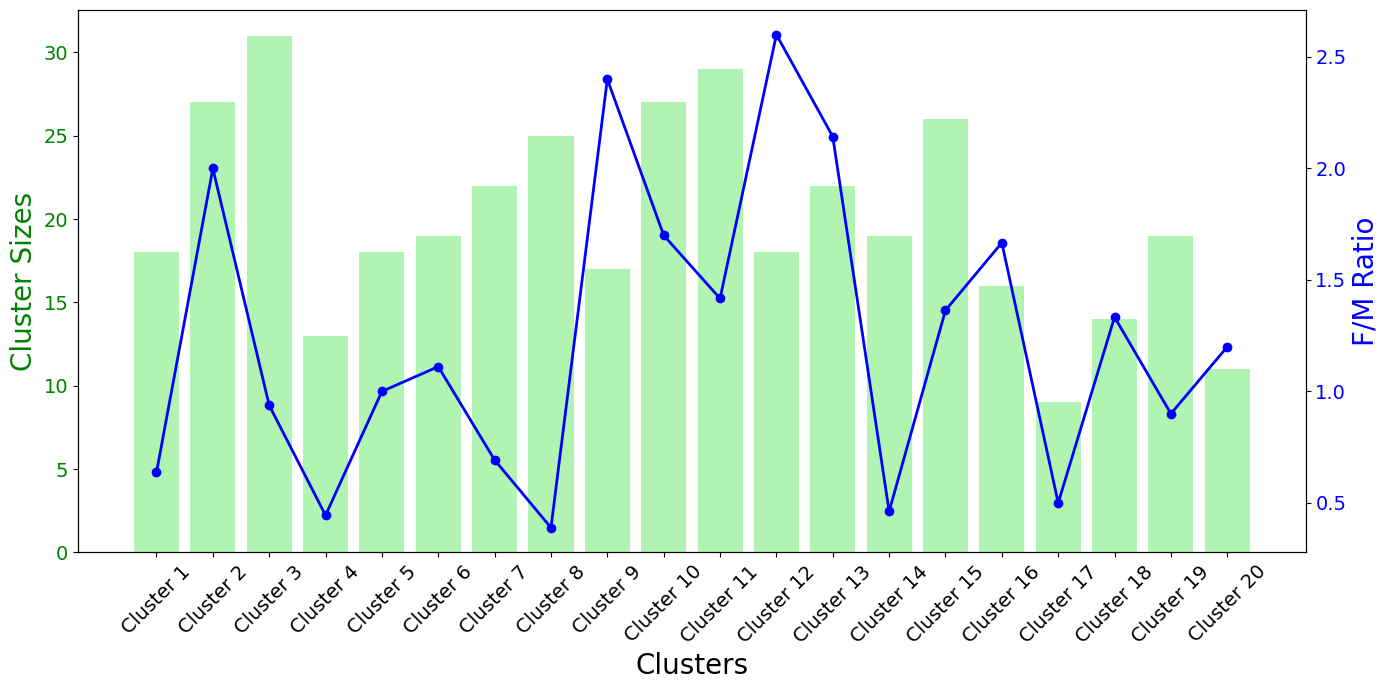

In [13]:
import matplotlib.pyplot as plt

clusters = [f"Cluster {i}" for i in range(1, 21)]
associated_numbers = ratios
cluster_sizes = sizes

fig, ax1 = plt.subplots(figsize=(14, 7))
# Bar chart for cluster sizes
ax1.bar(clusters, cluster_sizes, color="lightgreen", alpha=0.7, label="Cluster Sizes")
ax1.set_ylabel("Cluster Sizes", color="green", fontsize=20)
ax1.tick_params(axis="y", labelcolor="green", labelsize=14)
ax1.set_xlabel("Clusters", fontsize=20)
ax1.set_xticklabels(clusters, rotation=45, fontsize=14)

# Tighten the y-axis for cluster sizes
# ax1.set_ylim(min(cluster_sizes) - 50, max(cluster_sizes) + 50)

# Line plot for associated numbers on secondary axis
ax2 = ax1.twinx()
ax2.plot(clusters, associated_numbers, color="blue", marker="o", label="Associated Numbers", linewidth=2)
ax2.set_ylabel("F/M Ratio", color="blue", fontsize=20)
ax2.tick_params(axis="y", labelcolor="blue", labelsize=14)

# Add a title
# plt.title("Cluster Sizes and Associated Numbers with Tightened Y-Axis")
fig.tight_layout()
plt.savefig("Affinity_Admissions.eps", format="eps")
plt.show()